### Задание1. Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
classification_data, classification_labels = make_classification(n_samples=100, n_features=2, n_informative=2, n_classes=2,
    n_redundant=0, n_clusters_per_class=1, random_state=10)

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, test_size=0.3, random_state=1)

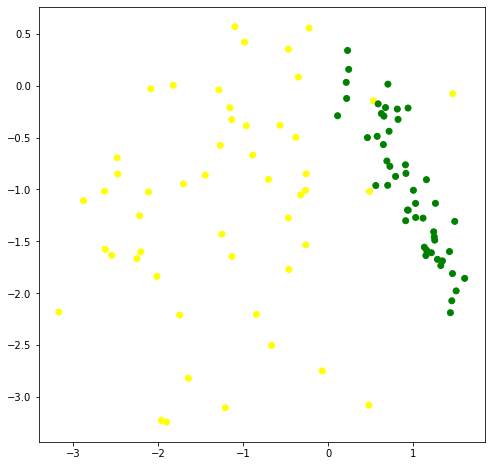

In [24]:
colors = ListedColormap(['green', 'yellow'])
light_colors = ListedColormap(['lightgreen', 'lightyellow'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [5]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] 
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [6]:
get_bootstrap(classification_data, classification_labels, 2)

[(array([[-0.70302192, -0.90290872],
         [-2.08758066, -0.03101632],
         [-1.2858872 , -0.04035584],
         [ 1.25388341, -1.48842279],
         [-2.87898397, -1.1082683 ],
         [ 0.79341915, -0.87427975],
         [-2.11477688, -1.02403124],
         [ 0.65656089, -0.29428493],
         [-1.90170665, -3.23974263],
         [-1.90170665, -3.23974263],
         [ 0.46209534, -0.50097219],
         [-1.13229397, -1.64517921],
         [-0.22471585,  0.55413394],
         [ 1.42752816, -1.59805052],
         [ 1.50589361, -1.9767807 ],
         [-1.2697409 , -0.57530882],
         [ 0.53201887, -0.14567033],
         [ 0.46209534, -0.50097219],
         [-0.26324669, -1.53381238],
         [ 0.48657561, -1.01783005],
         [ 0.53201887, -0.14567033],
         [-0.38093207, -0.49847008],
         [ 0.21261052,  0.0314066 ],
         [ 0.79341915, -0.87427975],
         [-0.32348688, -1.05155899],
         [ 0.6260228 , -0.26895555],
         [ 0.82240228, -0.32538729],
 

In [7]:
def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [8]:
get_subsample(2)

array([1])

In [9]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  
        self.t = t  
        self.true_branch = true_branch  
        self.false_branch = false_branch 

In [10]:
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {} 
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
 
        prediction = max(classes, key=classes.get)
        return prediction        

In [11]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [12]:
def gain(left_labels, right_labels, root_gini):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [13]:
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [14]:
def find_best_split(data, labels):
    
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) 
    
    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
        
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [15]:
def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [16]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [17]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [18]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [19]:
def tree_vote(forest, data):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    predictions_per_object = list(zip(*predictions))

    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [20]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [21]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [22]:
n_trees_list = np.array([1, 3, 10, 50])

Строим лес из 1 деревьев
Точность случайного леса из 1 деревьев на обучающей выборке: 95.714
Точность случайного леса из 1 деревьев на тестовой выборке: 100.000


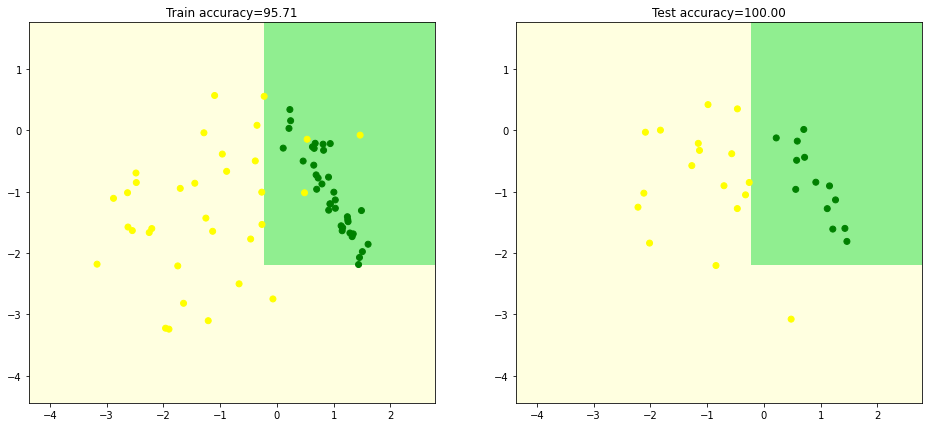

Строим лес из 3 деревьев
Точность случайного леса из 3 деревьев на обучающей выборке: 95.714
Точность случайного леса из 3 деревьев на тестовой выборке: 100.000


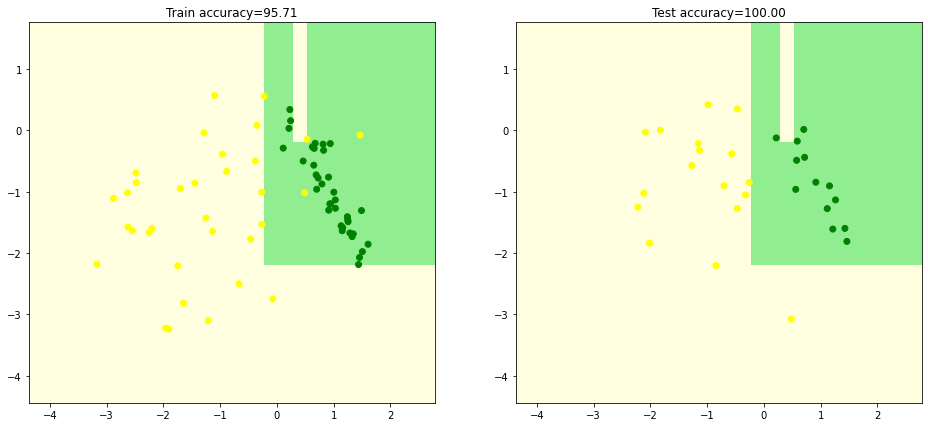

Строим лес из 10 деревьев
Точность случайного леса из 10 деревьев на обучающей выборке: 95.714
Точность случайного леса из 10 деревьев на тестовой выборке: 96.667


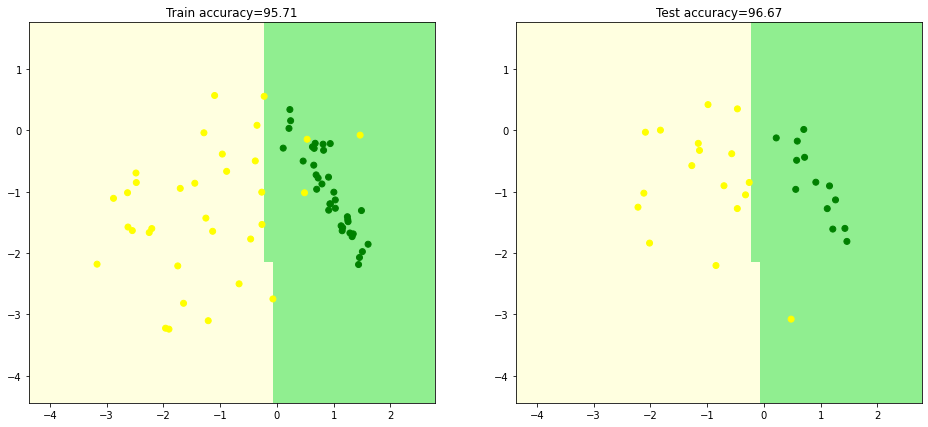

Строим лес из 50 деревьев
Точность случайного леса из 50 деревьев на обучающей выборке: 95.714
Точность случайного леса из 50 деревьев на тестовой выборке: 100.000


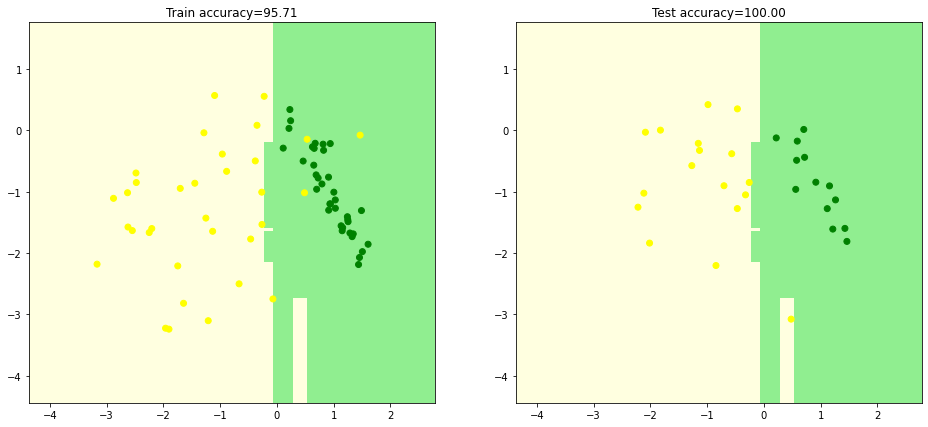

In [27]:
for n_trees in n_trees_list:
    my_forest = random_forest(train_data, train_labels, n_trees)
    
    print(f'Строим лес из {n_trees} деревьев')
    
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    
    plt.figure(figsize = (16, 7))
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

### Задание 2. Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

#### С ростом количества деревьев растет переобучение.

### Задание 3. Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

In [28]:
np.random.seed(42)

def get_oob_indices(sample_indices):
    indices = np.arange(len(sample_indices))
    return indices[~np.isin(indices, sample_indices)]


def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] 
    bootstrap_oob = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        oob_indices = get_oob_indices(sample_index)
        
        bootstrap_oob.append((b_data, b_labels, oob_indices))        
        
    return bootstrap_oob

In [29]:
b = get_bootstrap(train_data, train_labels, 1)
b[0][2].shape[0] * 100 / b[0][0].shape[0]

41.42857142857143

In [30]:
np.zeros((classification_data.shape[0], len(set(classification_labels))))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

In [31]:
def predict_oob(oob_predictions, oob_indices, tree, data):
    oob_data = data[oob_indices]
    prediction = predict(oob_data, tree)
    
    for i in range(len(oob_indices)):
        oob_predictions[oob_indices[i], prediction[i]] += 1
    return oob_predictions

    
def random_forest_oob(data, labels, n_trees):
    forest = []
    oob_predictions = np.zeros((data.shape[0], len(set(labels))))
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels, oob_indices in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
        oob_predictions = predict_oob(oob_predictions=oob_predictions,
                                      oob_indices=oob_indices,
                                      tree=tree,
                                      data=data)
        
    oob_score = accuracy_metric(labels, np.argmax(oob_predictions, axis=1))
    
    return forest, oob_score

In [32]:
forest, oob_score = random_forest_oob(classification_data, classification_labels, 3)
oob_score

84.0

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True, n_estimators=3)
rf.fit(classification_data, classification_labels)
rf.oob_score_

0.78

### Задание 4. (На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [35]:
def calc_entropy(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity += p * np.log2(p)
        
    return -impurity